In [7]:
import os
import numpy as np
from plot_params import *
from scipy.spatial.distance import cdist
from copy import deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation


In [2]:
def total_energy(pos):
    dist = cdist(pos, pos)
    li = np.tril_indices(len(pos), k=-1)
    pair_dist = dist[li]
    total_energy = (1 / pair_dist).sum()
    return total_energy


def accept_move(T, energy_after, energy_before):
    delta_energy = energy_after - energy_before
    if delta_energy < 0:
        return True
    # p = np.exp(- delta_energy / T) # fuck p
    p = T
    if np.random.rand() <= p:
        return True
    return False


def random_move(pos, i):
    og = deepcopy(pos)
    move = np.random.uniform(-1, 1, 2)
    normal_move = move / np.linalg.norm(move)
    pos[i] = og[i] + normal_move * stepsize
    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    return og


def run():
    # initialize particles
    r = np.random.rand(n)
    theta = np.random.rand(n) * 2 * np.pi
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    pos = np.stack((x, y), axis=1)

    # loop temp
    for j in tqdm(range(steps)):
        pos_history[j] = pos
        # loop charge
        for i in range(n):
            energy_before = total_energy(pos)
            # possible_pos = random_move(deepcopy(pos), i)
            possible_pos = random_move_with_drift(deepcopy(pos), i)
            energy_after = total_energy(possible_pos)
            if accept_move(T[j], energy_after, energy_before):
                pos = possible_pos
    return pos


def random_move_with_drift(pos, i):
    og = deepcopy(pos)

    # calc force
    r = cdist(pos, pos)
    r = r[i]
    r = r[r != 0]

    r_x = pos[:, 0].reshape(-1 , 1) - pos[:, 0]
    r_x = r_x[i]
    r_x = r_x[r_x != 0]

    r_y = pos[:, 1].reshape(-1 , 1) - pos[:, 1]
    r_y = r_y[i]
    r_y = r_y[r_y != 0]

    force = np.stack((r_x / np.abs(r ** 3), r_y / np.abs(r ** 3)), axis=1)
    total_force = force.sum(axis=0)

    normal_force_move = total_force / np.linalg.norm(total_force)

    # calc random
    random_move = np.random.uniform(-1, 1, 2)
    normal_random_move = random_move / np.linalg.norm(random_move)

    # add together
    pos[i] = og[i] + (normal_random_move * random_influence + normal_force_move * force_influence) * stepsize

    # check if outside of circle
    if np.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2) < circle_radius:
        return pos
    return og

In [3]:
# settings
steps = 100
stepsize = 0.05
n = 23
runs = 10
best_runs = 1
random_influence = 1
force_influence = 1
circle_radius = 1
pos_history = np.zeros((steps, n, 2))

# temp function
i = np.linspace(10, 1, steps)
B = 7
vu = 5
M = 5
T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) - 0.3# logistic because cool 

all_best = np.zeros((best_runs, n, 2))
for i in tqdm(range(best_runs)):

    # run 
    results = Parallel(n_jobs=-1, verbose=0)(delayed(run)() for _ in range(runs))
    results = np.array(results)

    # pick the best and worst
    quality = []
    for r in results:
        q = total_energy(r)
        quality.append(q)
    best = results[np.argmin(quality)]
    worst = results[np.argmax(quality)]
    all_best[i] = best

# save
np.save(f'best.npy', all_best)

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


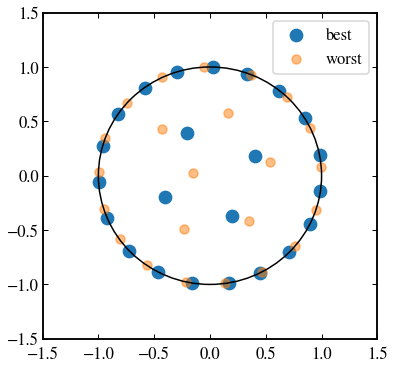

In [4]:
# plot best and worst outcome
plt.figure(figsize=(6, 6))
plt.scatter(best[:, 0], best[:, 1], label='best', s=150)
plt.scatter(worst[:, 0], worst[:, 1], label='worst', alpha=0.5)
plt.legend()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
plt.show() 

100%|██████████| 1000/1000 [00:02<00:00, 406.68it/s]


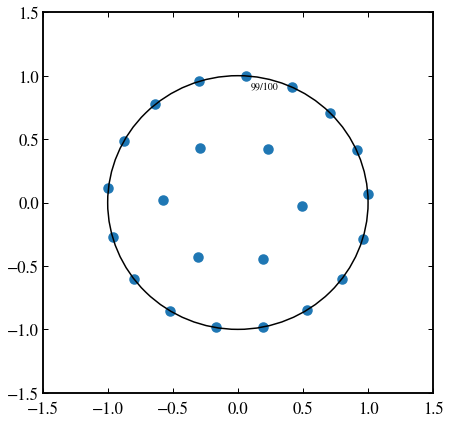

In [8]:
# settings
steps = 1000
stepsize = 0.05
n = 23
runs = 10
best_runs = 1
random_influence = 1
force_influence = 1
circle_radius = 1
pos_history = np.zeros((steps, n, 2))

# temp function
i = np.linspace(10, 1, steps)
B = 7
vu = 5
M = 5
T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) - 0.3# logistic because cool 

run()
frames = 100
pos_animate = pos_history[::steps//frames]
fig, ax = plt.subplots(figsize=(7, 7))
plot = ax.scatter(pos_animate[0, :, 0], pos_animate[0, :, 1])
text = ax.text(0.1, 0.9, '', fontsize=10)
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

def anim_func(i):
    plot.set_offsets(pos_animate[i])
    text.set_text(f'{i}/{frames}')
    return plot

sec = 5
animation = FuncAnimation(fig, anim_func, frames=frames, interval=sec / frames * 1e3, save_count=frames)
animation.save(f'kaas.mp4', dpi=100)

In [ ]:
# i = np.linspace(10, 1, steps)
# B = 7
# vu = 5
# M = 5
# T = 1 / (1 + np.exp(- B * (i - M)) ** (1 / vu)) 

# plt.plot(i, T)
